In [1]:
import os
import numpy as np
from collections import defaultdict
import json

import cv2
from cv2 import aruco

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D

In [2]:
with open('../TestA/Aruco_6x6_50.json') as f:
    aruco_info = json.load(f)
aruco_info

{'aruco': 'DICT_6X6_50', 'markerLength': 0.019, 'square_size': 0.15}

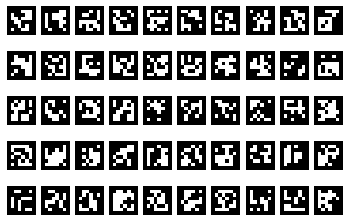

In [3]:
aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_50)

fig = plt.figure()
nx = 10
ny = 5
for i in range(nx*ny):
    ax = fig.add_subplot(ny,nx, i+1)
    img = aruco.drawMarker(aruco_dict,i, 700)
    plt.imshow(img, cmap = mpl.cm.gray, interpolation = "nearest")
    ax.axis("off")
plt.show()

In [4]:
def detect_aruco_markers_in_dir(dir_path, aruco_dict):
    #Store detected aruco positions in a dictionary for each camera
    #Treat it like a hash map with chaining
    aruco_mat = defaultdict(list)
    for img_files in os.listdir(dir_path):
        test_img = cv2.imread(os.path.join(dir_path, img_files))
        corners, ids, rejectedImgPoints = aruco.detectMarkers(test_img, aruco_dict)
        for (a_id, corner) in zip(ids, corners):
            aruco_mat[a_id[0]].append(corner)

    return aruco_mat

In [5]:
def read_cam_params_markers(dir_base_path):
    cam_fts_dict = {}
    for dirs in os.listdir(dir_base_path):
        dir_path = os.path.join(dir_base_path, dirs)
        if os.path.isdir(dir_path) and dirs.isnumeric():

            #Store camera parameters
            with open(os.path.join(dir_path, dirs + '_info.json')) as f:
                param_info = json.load(f)
                cam_fts_dict.update(param_info)

            #Detect of aruco points in all camera images
            aruco_mat = detect_aruco_markers_in_dir(os.path.join(dir_path, 'color'), aruco_dict)
            '''
            Since we will have too much information if we store each point, I will
            get the average (and if required variance) of each positon and add it 
            to another dictionary which will be under the key value of the camera
            '''
            aruco_mrkr_dict = {}
            for key, value_list in aruco_mat.items():
                avg_list = sum(value_list) / len(value_list)
                mrkr_dict = {}
                mrkr_dict['corners_avg'] = np.around(np.array(avg_list), 0)
                aruco_mrkr_dict[key] = mrkr_dict

            cam_fts_dict[dirs]['aruco_mrkr'] = aruco_mrkr_dict

            #Debug code
            '''
            test_img = cv2.imread(os.path.join(dir_path, 'color', '0000000000.jpeg'))
            test_val = [mrkrs['corners_avg'] for mrkrs in aruco_mrkr_dict.values()]
            test_key = np.array(list(aruco_mrkr_dict.keys())).reshape(-1, 1)
            frame_markers = aruco.drawDetectedMarkers(test_img, test_val, test_key)
            plt.imshow(frame_markers, origin = "upper",)
            plt.pause(1)
            #cv2.imshow("detected markers", frame_markers) #Use this for better clarity
            #cv2.waitKey(0)
            #'''
            if len(aruco_mat.keys()) != 12:
                print("Info: Only", len(aruco_mat.keys()), "aruco points detected in",dirs)

    #cv2.destroyAllWindows()
    return cam_fts_dict


In [6]:
cam_fts_dict = read_cam_params_markers('../TestA/')


Info: Only 10 aruco points detected in 839512060403


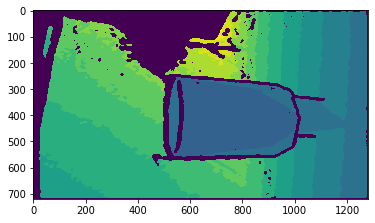

In [7]:
test_img = cv2.imread(os.path.join('../TestA/840412061635/depth', '0000000000.png'), 0)
hist = cv2.calcHist([test_img],[0],None,[16],[0,16])
plt.imshow(test_img, origin = "upper")
#plt.plot(hist)
plt.show() 

In [8]:
def get_3D_rot_arnd_y_for(angle):
    return np.array([[np.cos(angle), 0, np.sin(angle)], [0, 1, 0], 
                     [-np.sin(angle), 0, np.cos(angle)]])

In [9]:
'''
Set origin to cylinder centroid (approximately). Knowing the physical 
dimensions of the cylinder, we can choose the center of face which contains
markers [0:4] to be x = 0
Assumption: Equal spacing
Note: this assumption can be overcome by actually looking at the pixel distance 
and translating to real world distance but the error is minimal in this case
'''
cyl_fc_wd = 0.2
cyl_ht = 0.745
cyl_central_angle = np.pi / 4 #45 = 360 deg / 8 = pi / 4
side_len = aruco_info['square_size']

fc_horz_space = (cyl_fc_wd - 1 * side_len) / 2
fc_vert_space = 0.024 #(cyl_ht - 4 * side_len) / 5 gives 0.029. This is higher since the higher edge gap is not considered
# Actual space is around 2.4-2.5 cm. Obtained by averaging ratio between 
# Pixels used by marker to the gap between two markers on a face. 
# This is proportional to the physical dimensions in an undistorted camera

dist_edge_center = cyl_fc_wd / (2 * np.sin(cyl_central_angle / 2))
dist_face_center = cyl_fc_wd / (2 * np.tan(cyl_central_angle / 2))
dist_square_corner_center = side_len / (2 * (np.sin(np.arctan(side_len / (2 * dist_face_center)))))

vert_tran = np.array([0, -(fc_vert_space + side_len), 0])


#calculate world coordinate system for all 32 aruco markers
marker_pos = []
aruco_0_tl = np.array([0 - side_len / 2,  2 * side_len + 1.5 * fc_vert_space, 0 + dist_face_center])
aruco_0_coords = [aruco_0_tl, 
                 aruco_0_tl + [side_len, 0 , 0,],
                 aruco_0_tl + [side_len, -side_len, 0],
                 aruco_0_tl + [0, -side_len, 0]]
for idx in range(32):
    rot_angle = cyl_central_angle * (idx // 4)
    loc = np.asarray([get_3D_rot_arnd_y_for(rot_angle).dot(aruco_pt) + vert_tran * (idx % 4) for aruco_pt in aruco_0_coords])
    marker_pos.append(loc)
aruco_info['marker_pos'] = marker_pos

In [58]:
def calc_cam_pose_frm_aruco(cam_fts_dict, aruco_info):
    fig = plt.figure()
    fig.set_size_inches(18, 10, forward=True)
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('X axis')
    ax.set_ylabel('Z axis')
    ax.set_zlabel('Y axis')
    ax.set_xlim(-1.5, 1.5)
    ax.set_zlim(0, 1)
    ax.set_ylim(1.5, -1.5)
    
    ax.plot([0, 0.25], [0, 0], zs=[0, 0], color='r')
    ax.plot([0, 0], [0, 0], zs=[0, 0.25], color='g')
    ax.plot([0, 0], [0, 0.25], zs=[0, 0], color='b')
    ax.text(0, 0, 0, 'origin')
    
    output = {}
    for cam_num, cam in cam_fts_dict.items():
        #Intrinsics: focus, principal shift and distortion
        cameraMatrix = np.array([np.array(col) for col in cam['intrinsics']['color']]) 
        distCoeffs = np.array(cam['intrinsics']['color_coeffs'])

        corners = []
        objPoints = []
        for mrkr_id, mrkr_info in cam['aruco_mrkr'].items():
            corners.append(np.array(mrkr_info['corners_avg'][0]))
            objPoints.append(np.array(aruco_info['marker_pos'][mrkr_id]))
        
        objPoints = np.asarray(objPoints).reshape(-1,3)
        corners = np.asarray(corners).reshape(-1,2)
        retval, rvec, tvec = cv2.solvePnP(objPoints, corners, cameraMatrix, distCoeffs)
        rot, jacobian = cv2.Rodrigues(rvec)
        
        trans_mat = np.append(rot, tvec, axis = 1)
        trans_mat = np.append(trans_mat, [[0, 0, 0, 1]], axis = 0)
        
        output[cam_num] = trans_mat.tolist() #rel world to camera coordinates 
        
        #Find camera coordinates: (inverse transformation: from camera to rel world)
        inv_rot = rot.transpose()
        inv_tran = - inv_rot.dot(tvec)
        
        print(inv_tran)
        
        cam_coord_000 = inv_rot.dot(np.zeros([3,1])) + inv_tran
        cam_coord_100 = inv_rot.dot([[0.25], [0], [0]]) + inv_tran
        cam_coord_010 = inv_rot.dot([[0], [0.25], [0]]) + inv_tran
        cam_coord_001 = inv_rot.dot([[0], [0], [0.25]]) + inv_tran
        
        ax.plot([cam_coord_000[0][0], cam_coord_100[0][0]], [cam_coord_000[2][0], cam_coord_100[2][0]],
                zs=[cam_coord_000[1][0], cam_coord_100[1][0]], color='r')
        ax.plot([cam_coord_000[0][0], cam_coord_010[0][0]], [cam_coord_000[2][0], cam_coord_010[2][0]],
                zs=[cam_coord_000[1][0], cam_coord_010[1][0]], color='g')
        ax.plot([cam_coord_000[0][0], cam_coord_001[0][0]], [cam_coord_000[2][0], cam_coord_001[2][0]],
                zs=[cam_coord_000[1][0], cam_coord_001[1][0]], color='b')
        ax.text(cam_coord_000[0][0], cam_coord_000[2][0], cam_coord_000[1][0], cam_num)

        #debug
        '''
        test_img = cv2.imread(os.path.join('../TestA/', cam_num, 'color/0000000000.jpeg'))
        for mrkr_id, mrkr_info in cam['aruco_mrkr'].items():
            objPoints = aruco_info['marker_pos'][mrkr_id]
            retval, rvec, tvec = cv2.solvePnP(objPoints, mrkr_info['corners_avg'], cameraMatrix, distCoeffs)
            rvecs, tvecs, objPoints = aruco.estimatePoseSingleMarkers(mrkr_info['corners_avg'], aruco_info['square_size'], cameraMatrix, distCoeffs)
            aruco.drawAxis(test_img, cameraMatrix, distCoeffs, rvecs, tvecs, 0.01)

            cam['aruco_mrkr'][mrkr_id]['rvec'] = rvecs
            cam['aruco_mrkr'][mrkr_id]['tvec'] = tvecs
        cam['obj_pts'] = objPoints

        cv2.imshow("detected markers", test_img) #Use this for better clarity
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        #'''
    plt.show()
            
    return output

[[-0.67845748]
 [ 0.6766642 ]
 [ 1.41317449]]
[[ 1.49661758]
 [ 0.30353648]
 [-0.93974957]]
[[-1.20480477]
 [ 0.38235886]
 [ 1.20389466]]
[[0.01748835]
 [0.41566159]
 [1.5001316 ]]
[[-1.43830969]
 [ 0.43551962]
 [-1.1946552 ]]
[[0.95665931]
 [0.67749652]
 [1.37149678]]
[[1.52218829]
 [0.33017306]
 [1.10514365]]
[[ 0.04094154]
 [ 0.34090005]
 [-1.12728062]]


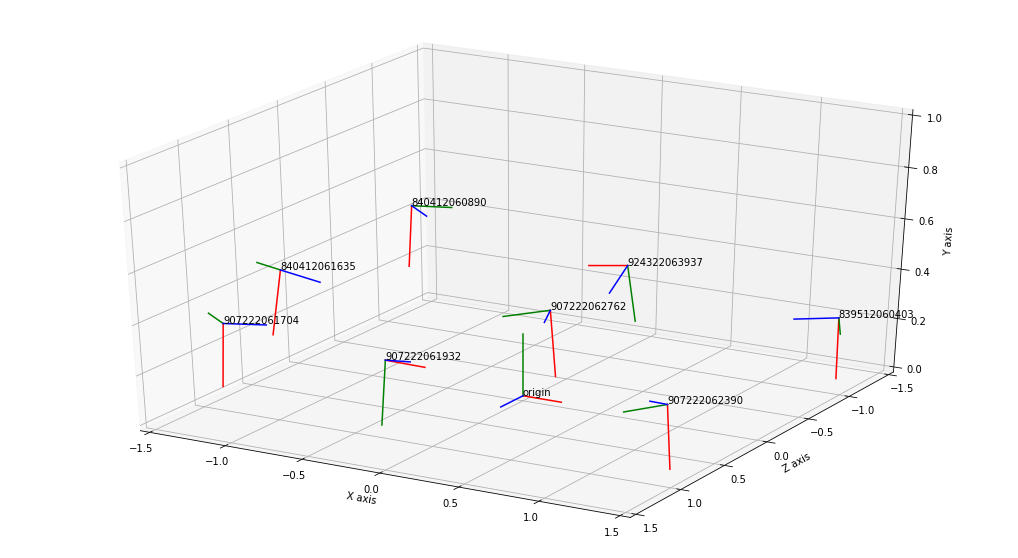

In [59]:
output = calc_cam_pose_frm_aruco(cam_fts_dict, aruco_info)

In [60]:
with open('color_cam_transform.txt', 'w') as outfile:
    json.dump(output, outfile, indent=4)